In [1]:
import os

directory = 'C:\\Users\\User\\OneDrive - Asia Pacific University\\FYP\\NewData'
train_dir = os.path.join(directory, 'train')
val_dir = os.path.join(directory, 'val')
test_dir = os.path.join(directory, 'test')

ResNet-50

In [2]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score

batch_size = 32
img_size   = (224, 224)
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

# Feature extraction with pretrained ResNet50
feature_extractor = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='avg'
)
X_train = feature_extractor.predict(train_gen, verbose=1)
y_train = train_gen.classes

# SMOTE on embeddings
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Original training distribution:", np.bincount(y_train))
print("Resampled distribution:         ", np.bincount(y_res))

# Test embeddings
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)
X_test = feature_extractor.predict(test_gen, verbose=1)
y_test = test_gen.classes

# Build a classifier head
num_classes = len(train_gen.class_indices)
input_dim  = X_res.shape[1]

model_resnet = Sequential([
    Input(shape=(input_dim,)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train base model
model_resnet.fit(
    X_res, y_res,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=2
)

y_train_pred_prob = model_resnet.predict(X_res, verbose=0)
y_train_pred      = np.argmax(y_train_pred_prob, axis=1)

class_names = list(train_gen.class_indices.keys())

print("📊 Training Classification Report:")
print(classification_report(y_res, y_train_pred, target_names=class_names))
print(f"Training Accuracy: {accuracy_score(y_res, y_train_pred):.4f}")

# Validation embeddings
val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)
X_val = feature_extractor.predict(val_gen, verbose=1)
y_val = val_gen.classes

# Evaluation on the validation and test set
y_val_pred_prob = model_resnet.predict(X_val, verbose=0)
y_val_pred      = np.argmax(y_val_pred_prob, axis=1)

print("\n📊 Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=class_names))
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")

y_test_pred_prob = model_resnet.predict(X_test, verbose=0)
y_test_pred      = np.argmax(y_test_pred_prob, axis=1)

print("\n📊 Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")


Found 15251 images belonging to 5 classes.


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


477/477 ━━━━━━━━━━━━━━━━━━━━ 1778s 4s/step
Original training distribution: [4208 4051 2448 2374 2170]
Resampled distribution:          [4208 4208 4208 4208 4208]
Found 1907 images belonging to 5 classes.


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step
Epoch 1/10
526/526 - 13s - 26ms/step - accuracy: 0.4458 - loss: 1.3001 - val_accuracy: 0.6219 - val_loss: 1.0128
Epoch 2/10
526/526 - 7s - 13ms/step - accuracy: 0.5704 - loss: 1.0371 - val_accuracy: 0.6918 - val_loss: 0.8331
Epoch 3/10
526/526 - 7s - 14ms/step - accuracy: 0.6062 - loss: 0.9483 - val_accuracy: 0.7051 - val_loss: 0.7840
Epoch 4/10
526/526 - 7s - 14ms/step - accuracy: 0.6410 - loss: 0.8754 - val_accuracy: 0.7048 - val_loss: 0.7591
Epoch 5/10
526/526 - 7s - 14ms/step - accuracy: 0.6712 - loss: 0.8217 - val_accuracy: 0.7519 - val_loss: 0.6917
Epoch 6/10
526/526 - 8s - 15ms/step - accuracy: 0.6865 - loss: 0.7748 - val_accuracy: 0.7731 - val_loss: 0.6365
Epoch 7/10
526/526 - 7s - 14ms/step - accuracy: 0.7056 - loss: 0.7407 - val_accuracy: 0.7802 - val_loss: 0.5910
Epoch 8/10
526/526 - 7s - 13ms/step - accuracy: 0.7231 - loss: 0.7028 - val_accuracy: 0.7750 - val_loss: 0.6055
Epoch 9/10
526/526 - 7s - 14ms/step - accuracy: 0.7361 - loss: 

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step

📊 Validation Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       526
           1       0.70      0.72      0.71       506
           2       0.56      0.65      0.60       306
           3       0.77      0.73      0.75       297
           4       0.82      0.85      0.84       271

    accuracy                           0.74      1906
   macro avg       0.74      0.74      0.74      1906
weighted avg       0.75      0.74      0.74      1906

Validation Accuracy: 0.7371

📊 Test Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.70      0.76       526
           1       0.69      0.75      0.72       507
           2       0.55      0.67      0.61       306
           3       0.74      0.68      0.71       297
           4       0.83      0.83      0.83       271

    accuracy                           0.72      

Hyperparameter Tuning

RandomizedSearchCV

In [ ]:
import numpy as np
from scipy.stats import uniform, loguniform
from sklearn.base import BaseEstimator
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

random_state = 42
class ResNetHeadEstimator(BaseEstimator):
    _estimator_type = "classifier"
    
    def __init__(self, dense_units=256, dropout=0.5, lr=1e-4,
                 epochs=10, batch_size=32, verbose=0):
        self.dense_units = dense_units
        self.dropout     = dropout
        self.lr          = lr
        self.epochs      = epochs
        self.batch_size  = batch_size
        self.verbose     = verbose

    def fit(self, X, y):
        K.clear_session()
        self.model_ = Sequential([
            Input(shape=(input_dim,)),
            Dense(self.dense_units, activation='relu'),
            Dropout(self.dropout),
            Dense(num_classes,   activation='softmax')
        ])
        self.model_.compile(
            optimizer=Adam(learning_rate=self.lr),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        self.model_.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose
        )
        return self

    def predict(self, X):
        proba = self.model_.predict(X, verbose=0)
        return np.argmax(proba, axis=1)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))


# Hyperparameter search space
param_dist = {
    'dense_units': [128, 256, 512],
    'dropout':     uniform(0.2, 0.5),
    'lr':          loguniform(1e-5, 1e-3),
    'epochs':     [5, 10, 20],
    'batch_size': [16, 32, 64],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

rs = RandomizedSearchCV(
    estimator=ResNetHeadEstimator(verbose=0),
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    random_state=random_state,
    verbose=1
)

rs.fit(X_res, y_res)

print("🔍 Best hyperparameters:", rs.best_params_)
print(f"🔍 Best CV accuracy: {rs.best_score_:.4f}")

# Evaluation of the best estimator on train and test
best_est = rs.best_estimator_

# Training set report
y_train_pred = best_est.predict(X_res)
print("\n📊 Training Classification Report:")
print(classification_report(y_res, y_train_pred))
print(f"Training Accuracy: {accuracy_score(y_res, y_train_pred):.4f}")

# Validation set report
y_val_pred = best_est.predict(X_val)
print("\n📊 Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=class_names))
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits

🔍 Best hyperparameters: {'batch_size': 32, 'dense_units': 512, 'dropout': 0.24998745790900145, 'epochs': 20, 'lr': 0.0005399484409787432}
🔍 Best CV accuracy: 0.8568

📊 Training Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      4208
           1       0.90      0.92      0.91      4208
           2       0.96      0.97      0.96      4208
           3       1.00      0.92      0.95      4208
           4       1.00      0.99      0.99      4208

    accuracy                           0.95     21040
   macro avg       0.95      0.95      0.95     21040
weighted avg       0.95      0.95      0.95     21040

Training Accuracy: 0.9515

📊 Validation Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       526
           1       0.77      0.79      0.78       506
           2       0.77

Keras Tuner - Random Search

In [4]:
import numpy as np
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score

embed_dim   = X_res.shape[1]
num_classes = len(class_names)

def build_resnet_head(hp):
    model = Sequential([
        Input(shape=(embed_dim,)),
        Dense(hp.Choice('units', [128, 256, 512]), activation='relu'),
        Dropout(hp.Float('dropout_rate', 0.2, 0.6, step=0.1)),
        Dense(num_classes, activation='softmax')
    ])

    lr = hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_resnet_head,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=2,
    directory='kt_resnet50_head',
    project_name='resnet50_head'
)

tuner.search(
    X_res, y_res,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=3)],
    verbose=2
)

best_hp    = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("🔍 Best hyperparameters:")
print(f"  units         = {best_hp.get('units')}")
print(f"  dropout_rate  = {best_hp.get('dropout_rate'):.2f}")
print(f"  learning_rate = {best_hp.get('learning_rate'):.1e}")

# Training
y_train_pred = np.argmax(best_model.predict(X_res, verbose=0), axis=1)
print("\n📊 Training Classification Report:")
print(classification_report(y_res, y_train_pred, target_names=class_names, digits=4))
print(f"Training Accuracy: {accuracy_score(y_res, y_train_pred):.4f}")

# Validation
y_val_pred = np.argmax(best_model.predict(X_val, verbose=0), axis=1)
print("\n📊 Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=class_names, digits=4))
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")

Trial 15 Complete [00h 09m 34s]
val_accuracy: 0.8263378739356995

Best val_accuracy So Far: 0.8263378739356995
Total elapsed time: 01h 37m 58s


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


🔍 Best hyperparameters:
  units         = 512
  dropout_rate  = 0.20
  learning_rate = 3.4e-04

📊 Training Classification Report:
              precision    recall  f1-score   support

           0     0.9779    0.9482    0.9628      4208
           1     0.9452    0.9710    0.9579      4208
           2     0.9832    0.9867    0.9849      4208
           3     0.9896    0.9926    0.9911      4208
           4     0.9995    0.9960    0.9977      4208

    accuracy                         0.9789     21040
   macro avg     0.9791    0.9789    0.9789     21040
weighted avg     0.9791    0.9789    0.9789     21040

Training Accuracy: 0.9789

📊 Validation Classification Report:
              precision    recall  f1-score   support

           0     0.8780    0.8346    0.8558       526
           1     0.7838    0.8241    0.8035       506
           2     0.7653    0.7778    0.7715       306
           3     0.8285    0.8620    0.8449       297
           4     0.9252    0.8672    0.8952    

Optuna

In [3]:
import optuna
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def objective(trial):
    units        = trial.suggest_categorical('units',        [128, 256, 512])
    dropout_rate = trial.suggest_float(      'dropout_rate', 0.2, 0.6, step=0.1)
    lr           = trial.suggest_loguniform( 'learning_rate', 1e-5, 1e-3)
    batch_size   = trial.suggest_categorical('batch_size',   [16, 32, 64])
    epochs       = trial.suggest_categorical('epochs',       [5, 10, 20])

    model = Sequential([
        Input(shape=(X_res.shape[1],)),
        Dense(units, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(class_names), activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    es = EarlyStopping('val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_res, y_res,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    return max(history.history['val_accuracy'])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)

bp = study.best_params
best_model = Sequential([
    Input(shape=(X_res.shape[1],)),
    Dense(bp['units'], activation='relu'),
    Dropout(bp['dropout_rate']),
    Dense(len(class_names), activation='softmax')
])
best_model.compile(
    optimizer=Adam(learning_rate=bp['learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
best_model.fit(
    X_res, y_res,
    validation_data=(X_val, y_val),
    epochs=bp['epochs'],
    batch_size=bp['batch_size'],
    callbacks=[EarlyStopping('val_loss', patience=3, restore_best_weights=True)],
    verbose=2
)

def report(name, X, y):
    preds = np.argmax(best_model.predict(X, verbose=0), axis=1)
    acc   = accuracy_score(y, preds)
    print(f"\n📊 {name} (acc = {acc:.4f})")
    print(classification_report(y, preds, target_names=class_names, digits=4))

report("Training (SMOTE)", X_res, y_res)
report("Validation",      X_val,   y_val)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-05 00:40:39,439] A new study created in memory with name: no-name-ef1b3e3e-47b4-43f7-8ec6-87df2fffb781
C:\Users\User\AppData\Local\Temp\ipykernel_16776\2597903737.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr           = trial.suggest_loguniform( 'learning_rate', 1e-5, 1e-3)


[I 2025-07-05 00:41:08,080] Trial 0 finished with value: 0.6998950839042664 and parameters: {'units': 256, 'dropout_rate': 0.6, 'learning_rate': 0.00042330929939701637, 'batch_size': 64, 'epochs': 5}. Best is trial 0 with value: 0.6998950839042664.
[I 2025-07-05 00:44:00,099] Trial 1 finished with value: 0.676810085773468 and parameters: {'units': 512, 'dropout_rate': 0.5, 'learning_rate': 1.0839105610320066e-05, 'batch_size': 16, 'epochs': 10}. Best is trial 0 with value: 0.6998950839042664.
[I 2025-07-05 00:44:09,117] Trial 2 finished with value: 0.7486883401870728 and parameters: {'units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.00030134862222464643, 'batch_size': 64, 'epochs': 5}. Best is trial 2 with value: 0.7486883401870728.
[I 2025-07-05 00:44:34,795] Trial 3 finished with value: 0.7869884371757507 and parameters: {'units': 512, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0001769506950326535, 'batch_size': 64, 'epochs': 10}. Best is trial 3 with value: 0.786988

Best hyperparameters: {'units': 512, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00020235003654275557, 'batch_size': 16, 'epochs': 20}
Epoch 1/20
1315/1315 - 11s - 9ms/step - accuracy: 0.5809 - loss: 1.0050 - val_accuracy: 0.6212 - val_loss: 0.8813
Epoch 2/20
1315/1315 - 10s - 8ms/step - accuracy: 0.6908 - loss: 0.7577 - val_accuracy: 0.6689 - val_loss: 0.7879
Epoch 3/20
1315/1315 - 10s - 8ms/step - accuracy: 0.7409 - loss: 0.6444 - val_accuracy: 0.7324 - val_loss: 0.6602
Epoch 4/20
1315/1315 - 10s - 8ms/step - accuracy: 0.7781 - loss: 0.5634 - val_accuracy: 0.7335 - val_loss: 0.6444
Epoch 5/20
1315/1315 - 10s - 8ms/step - accuracy: 0.8004 - loss: 0.5063 - val_accuracy: 0.7476 - val_loss: 0.6237
Epoch 6/20
1315/1315 - 10s - 8ms/step - accuracy: 0.8239 - loss: 0.4544 - val_accuracy: 0.7608 - val_loss: 0.5983
Epoch 7/20
1315/1315 - 10s - 8ms/step - accuracy: 0.8403 - loss: 0.4132 - val_accuracy: 0.7728 - val_loss: 0.5722
Epoch 8/20
1315/1315 - 10s - 8ms/step - accuracy: 0.853

Keras Tuner - Grid Search

In [3]:
import numpy as np
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score

batch_size = 32
img_size   = (224, 224)
datagen    = ImageDataGenerator(preprocessing_function=preprocess_input)
feature_extractor = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_embeddings(directory):
    gen = datagen.flow_from_directory(
        directory, target_size=img_size,
        batch_size=batch_size, class_mode='sparse',
        shuffle=False
    )
    return feature_extractor.predict(gen, verbose=1), gen.classes

X_train, y_train = extract_embeddings(train_dir)
X_val,   y_val   = extract_embeddings(val_dir)
X_test,  y_test  = extract_embeddings(test_dir)
class_names      = list(datagen.flow_from_directory(train_dir).class_indices.keys())

sm       = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

def build_head(hp):
    inputs = keras.Input(shape=(X_res.shape[1],))
    x = inputs

    units = hp.Choice('units', [128, 256, 512])
    x = Dense(units, activation='relu')(x)
    drop = hp.Float('dropout_rate', 0.2, 0.6, step=0.1)
    x = Dropout(drop)(x)
    outputs = Dense(len(class_names), activation='softmax')(x)

    # sampling batch_size & epochs
    hp.Choice('batch_size', [16, 32, 64])
    hp.Choice('epochs',     [5, 10, 20])

    model = keras.Model(inputs, outputs)
    lr = hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

class HeadGridSearch(kt.GridSearch):
    def run_trial(self, trial, X, y, validation_data=None, **fit_kwargs):
        hp     = trial.hyperparameters
        batch  = hp.get('batch_size')
        epochs = hp.get('epochs')
        return super().run_trial(
            trial, X, y,
            batch_size=batch,
            epochs=epochs,
            validation_data=validation_data,
            callbacks=[EarlyStopping('val_loss', patience=3, restore_best_weights=True)],
            verbose=2
        )

tuner = HeadGridSearch(
    build_head,
    objective='val_accuracy',
    directory='kt_resnet_head_grid',
    project_name='resnet50_head'
)

tuner.search_space_summary()

tuner.search(
    X_res, y_res,
    validation_data=(X_val, y_val)
)

best_hp    = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("🔍 Best hyperparameters:")
print(f" units         = {best_hp.get('units')}")
print(f" dropout_rate  = {best_hp.get('dropout_rate'):.2f}")
print(f" learning_rate = {best_hp.get('learning_rate'):.1e}")
print(f" batch_size    = {best_hp.get('batch_size')}")
print(f" epochs        = {best_hp.get('epochs')}")

def report(name, X, y):
    preds = np.argmax(best_model.predict(X, verbose=0), axis=1)
    acc   = accuracy_score(y, preds)
    print(f"\n📊 {name} (acc={acc:.4f})")
    print(classification_report(y, preds, target_names=class_names, digits=4))

report("Training (SMOTE)", X_res, y_res)
report("Validation",      X_val,   y_val)

C:\Users\User\AppData\Local\Temp\ipykernel_21568\1910977490.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Found 15251 images belonging to 5 classes.


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


477/477 ━━━━━━━━━━━━━━━━━━━━ 1441s 3s/step
Found 1906 images belonging to 5 classes.
60/60 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step
Found 1907 images belonging to 5 classes.
60/60 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step
Found 15251 images belonging to 5 classes.
Reloading Tuner from kt_resnet_head_grid\resnet50_head\tuner0.json
Search space summary
Default search space size: 5
units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
batch_size (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
epochs (Choice)
{'default': 5, 'conditions': [], 'values': [5, 10, 20], 'ordered': True}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}



c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


🔍 Best hyperparameters:
 units         = 512
 dropout_rate  = 0.30
 learning_rate = 3.2e-04
 batch_size    = 16
 epochs        = 20

📊 Training (SMOTE) (acc=0.9659)
              precision    recall  f1-score   support

           0     0.9197    0.9748    0.9465      4208
           1     0.9672    0.9033    0.9341      4208
           2     0.9753    0.9663    0.9708      4208
           3     0.9763    0.9872    0.9817      4208
           4     0.9938    0.9981    0.9960      4208

    accuracy                         0.9659     21040
   macro avg     0.9665    0.9659    0.9658     21040
weighted avg     0.9665    0.9659    0.9658     21040


📊 Validation (acc=0.8410)
              precision    recall  f1-score   support

           0     0.8342    0.8802    0.8566       526
           1     0.8430    0.7747    0.8074       506
           2     0.8076    0.7680    0.7873       306
           3     0.8258    0.8620    0.8435       297
           4     0.9018    0.9483    0.9245     

Best Model

In [4]:
report("Test", X_test,  y_test)


📊 Test (acc=0.8228)
              precision    recall  f1-score   support

           0     0.8205    0.8517    0.8358       526
           1     0.8126    0.7613    0.7862       507
           2     0.7944    0.7451    0.7690       306
           3     0.7944    0.8586    0.8252       297
           4     0.9065    0.9299    0.9180       271

    accuracy                         0.8228      1907
   macro avg     0.8257    0.8293    0.8268      1907
weighted avg     0.8224    0.8228    0.8219      1907



Graphs

Learning Curve

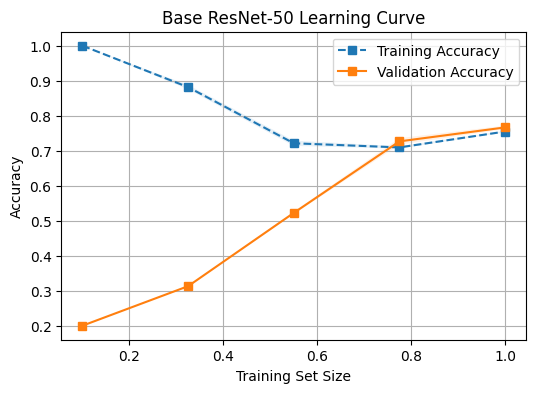

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

def plot_learning_curve_manual(model, X, y, title="Learning Curve", n_splits=3):
    train_sizes = np.linspace(0.1, 1.0, 5)
    
    train_scores = []
    val_scores = []
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for fraction in train_sizes:
        fold_train_scores = []
        fold_val_scores = []
        
        for train_idx, val_idx in cv.split(X, y):
            n_samples = int(len(train_idx) * fraction)
            partial_train_idx = train_idx[:n_samples]
            
            X_train = X[partial_train_idx]
            y_train = y[partial_train_idx]
            X_val = X[val_idx]
            y_val = y[val_idx]
            
            model_clone = Sequential.from_config(model.get_config())
            model_clone.compile(
                optimizer=Adam(learning_rate=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            
            history = model_clone.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=10,
                batch_size=32,
                verbose=0
            )
            
            best_val_acc = max(history.history['val_accuracy'])
            best_train_acc = max(history.history['accuracy'])
            
            fold_train_scores.append(best_train_acc)
            fold_val_scores.append(best_val_acc)
        
        train_scores.append(fold_train_scores)
        val_scores.append(fold_val_scores)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, 's--', label='Training Accuracy')
    plt.plot(train_sizes, val_mean, 's-', label='Validation Accuracy')
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    
    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot learning curve
plot_learning_curve_manual(
    model=model_resnet,
    X=X_res,
    y=y_res,
    title="Base ResNet-50 Learning Curve"
)

Epoch 1/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.9281 - loss: 0.1861 - val_accuracy: 0.8326 - val_loss: 0.4897
Epoch 2/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.9391 - loss: 0.1677 - val_accuracy: 0.8179 - val_loss: 0.5214
Epoch 3/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.9376 - loss: 0.1664 - val_accuracy: 0.8227 - val_loss: 0.5181
Epoch 4/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.9385 - loss: 0.1650 - val_accuracy: 0.8389 - val_loss: 0.4410
Epoch 5/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.9447 - loss: 0.1467 - val_accuracy: 0.8332 - val_loss: 0.4992
Epoch 6/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.9496 - loss: 0.1399 - val_accuracy: 0.8290 - val_loss: 0.5117
Epoch 7/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.9431 - loss: 0.1478 - val_accuracy: 0.8258 - val_loss: 0.5262


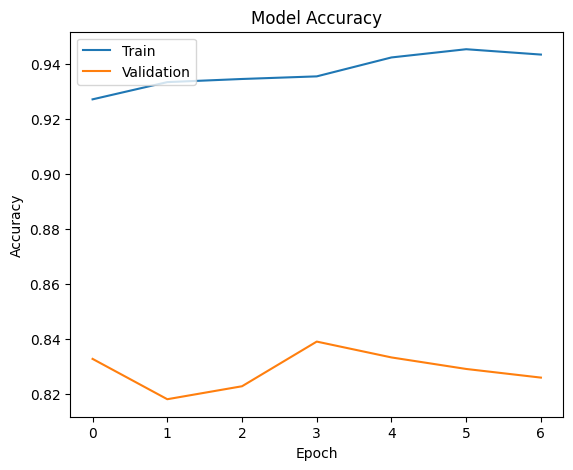

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((X_res, y_res)).batch(int(best_hp.get('batch_size')))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(int(best_hp.get('batch_size')))
best_model.compile(
    optimizer=Adam(learning_rate=best_hp.get('learning_rate')),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = best_model.fit(
    X_res, 
    y_res,
    batch_size=int(best_hp.get('batch_size')),
    epochs=int(best_hp.get('epochs')),
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Create the learning curves plot
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()



Loss Curve

Epoch 1/20
658/658 - 15s - 23ms/step - accuracy: 0.4894 - loss: 1.2312 - val_accuracy: 0.6049 - val_loss: 0.9696
Epoch 2/20
658/658 - 8s - 12ms/step - accuracy: 0.6076 - loss: 0.9561 - val_accuracy: 0.6432 - val_loss: 0.8701
Epoch 3/20
658/658 - 8s - 13ms/step - accuracy: 0.6500 - loss: 0.8541 - val_accuracy: 0.6810 - val_loss: 0.7874
Epoch 4/20
658/658 - 10s - 15ms/step - accuracy: 0.6834 - loss: 0.7868 - val_accuracy: 0.6873 - val_loss: 0.7765
Epoch 5/20
658/658 - 9s - 13ms/step - accuracy: 0.7083 - loss: 0.7279 - val_accuracy: 0.6994 - val_loss: 0.7231
Epoch 6/20
658/658 - 9s - 13ms/step - accuracy: 0.7280 - loss: 0.6826 - val_accuracy: 0.7193 - val_loss: 0.7016
Epoch 7/20
658/658 - 11s - 17ms/step - accuracy: 0.7488 - loss: 0.6382 - val_accuracy: 0.7419 - val_loss: 0.6459
Epoch 8/20
658/658 - 9s - 13ms/step - accuracy: 0.7642 - loss: 0.6064 - val_accuracy: 0.7471 - val_loss: 0.6365
Epoch 9/20
658/658 - 8s - 12ms/step - accuracy: 0.7787 - loss: 0.5744 - val_accuracy: 0.7503 - val_lo

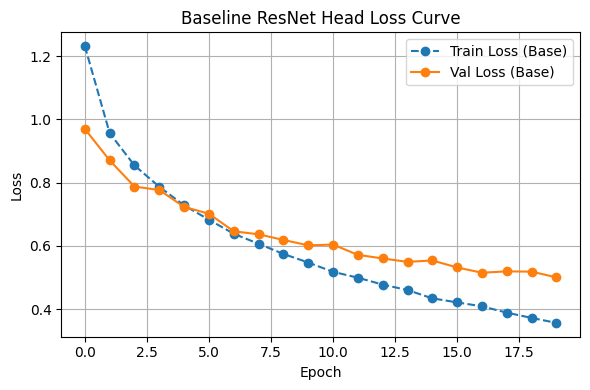

Epoch 1/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.9381 - loss: 0.1608 - val_accuracy: 0.8379 - val_loss: 0.4654
Epoch 2/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.9428 - loss: 0.1509 - val_accuracy: 0.8237 - val_loss: 0.4832
Epoch 3/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9486 - loss: 0.1363 - val_accuracy: 0.8237 - val_loss: 0.5531
Epoch 4/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.9481 - loss: 0.1359 - val_accuracy: 0.8263 - val_loss: 0.5233


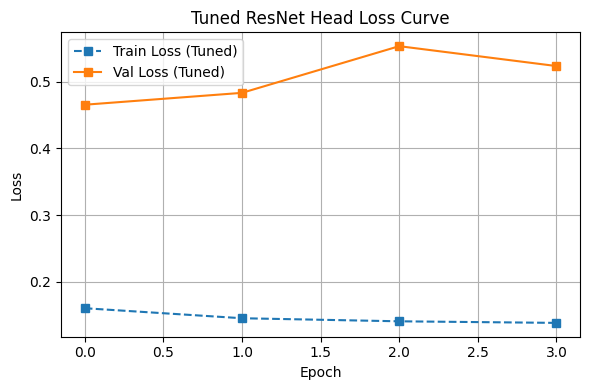

In [16]:
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Baseline model loss curve
K.clear_session()
model_base = Sequential([
    Input(shape=(input_dim,)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model_base.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_base = model_base.fit(
    X_res, y_res,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=2
)

plt.figure(figsize=(6,4))
plt.plot(history_base.history['loss'], '--o', label='Train Loss (Base)')
plt.plot(history_base.history['val_loss'], '-o', label='Val Loss (Base)')
plt.title('Baseline ResNet Head Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Tuned model loss curve
K.clear_session()
best_model.compile(
    optimizer=Adam(learning_rate=best_hp.get('learning_rate')),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_tuned = best_model.fit(
    X_res, 
    y_res,
    batch_size=int(best_hp.get('batch_size')),
    epochs=int(best_hp.get('epochs')),
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

plt.figure(figsize=(6,4))
plt.plot(history_tuned.history['loss'], '--s', label='Train Loss (Tuned)')
plt.plot(history_tuned.history['val_loss'], '-s', label='Val Loss (Tuned)')
plt.title('Tuned ResNet Head Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Confusion Matrix

<Figure size 500x500 with 0 Axes>

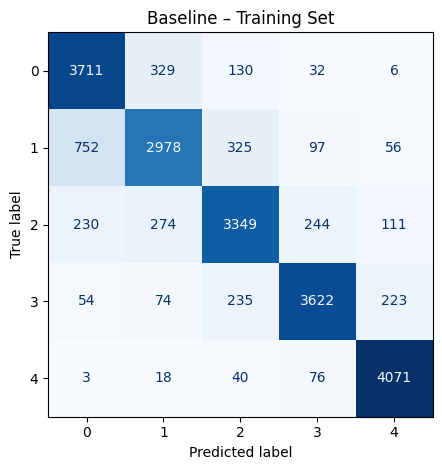

<Figure size 500x500 with 0 Axes>

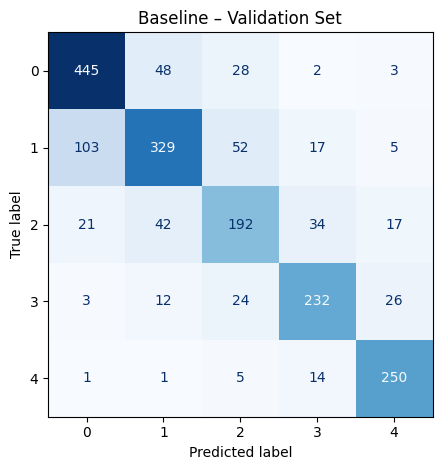

<Figure size 500x500 with 0 Axes>

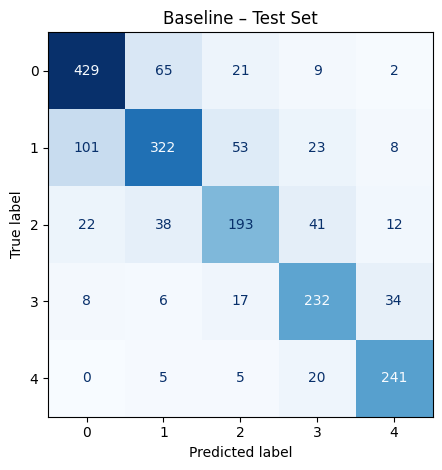

<Figure size 500x500 with 0 Axes>

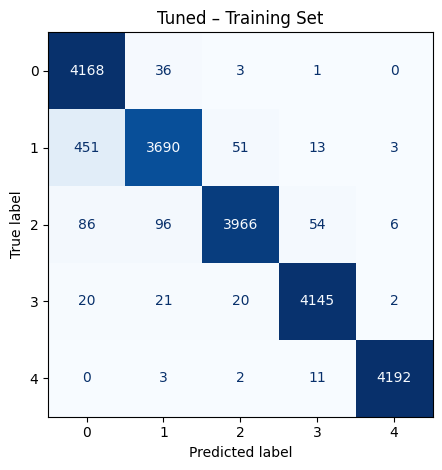

<Figure size 500x500 with 0 Axes>

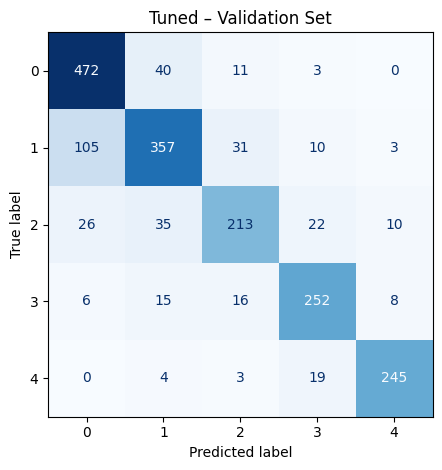

<Figure size 500x500 with 0 Axes>

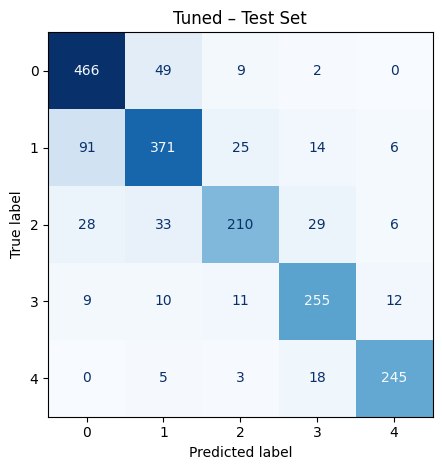

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

base_est = ResNetHeadEstimator(verbose=0)
base_est.fit(X_res, y_res)

# helper function
def plot_cm(model, X, y, split_name, model_name):
    y_pred = model.predict(X)
    cm     = confusion_matrix(y, y_pred)
    disp   = ConfusionMatrixDisplay(cm, display_labels=class_names)
    plt.figure(figsize=(5,5))
    disp.plot(cmap=plt.cm.Blues, colorbar=False)
    plt.title(f"{model_name} – {split_name}")
    plt.tight_layout()
    plt.show()

for model, name in [(base_est, "Baseline"), (best_model, "Tuned")]:
    for split_name, X_split, y_split in [
        ("Training Set",   X_res,  y_res),
        ("Validation Set", X_val,  y_val),
        ("Test Set",       X_test, y_test),
    ]:
        plot_cm(model, X_split, y_split, split_name, name)


ROC Curve

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


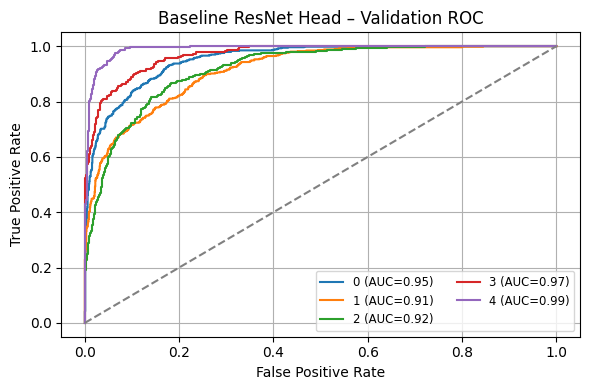

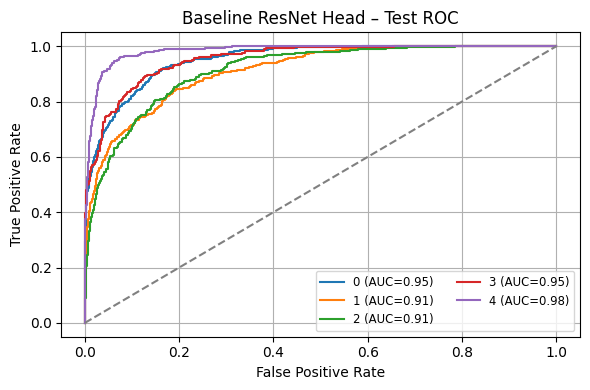

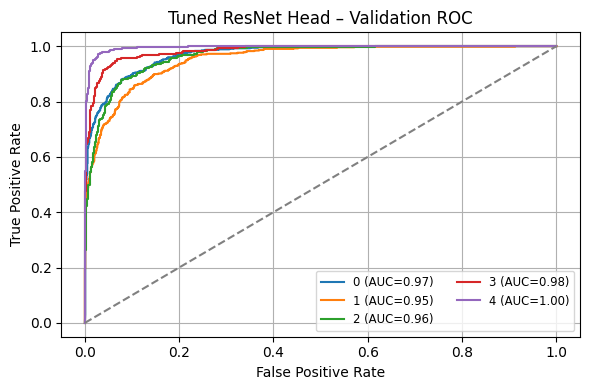

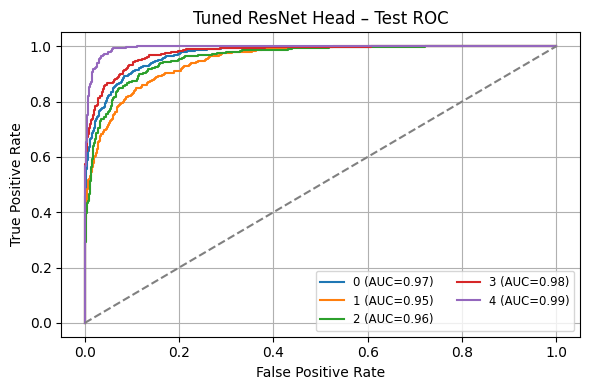

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# binarize true labels
num_classes    = len(class_names)
y_val_bin      = label_binarize(y_val,    classes=list(range(num_classes)))
y_test_bin     = label_binarize(y_test,   classes=list(range(num_classes)))

y_val_prob_base   = model_resnet.predict(X_val)
y_test_prob_base  = model_resnet.predict(X_test)
y_val_prob_tuned  = best_model.predict(X_val)
y_test_prob_tuned = best_model.predict(X_test)

def compute_roc(y_bin, y_prob):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

fpr_val_base,  tpr_val_base,  auc_val_base   = compute_roc(y_val_bin,      y_val_prob_base)
fpr_test_base, tpr_test_base, auc_test_base  = compute_roc(y_test_bin,     y_test_prob_base)
fpr_val_tuned, tpr_val_tuned, auc_val_tuned  = compute_roc(y_val_bin,      y_val_prob_tuned)
fpr_test_tuned,tpr_test_tuned,auc_test_tuned = compute_roc(y_test_bin,     y_test_prob_tuned)

def plot_roc(fpr, tpr, aucs, title):
    plt.figure(figsize=(6,4))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC={aucs[i]:.2f})')
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best', fontsize='small', ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc(fpr_val_base,  tpr_val_base,  auc_val_base,   "Baseline ResNet Head – Validation ROC")
plot_roc(fpr_test_base, tpr_test_base, auc_test_base,  "Baseline ResNet Head – Test ROC")
plot_roc(fpr_val_tuned, tpr_val_tuned, auc_val_tuned,  "Tuned ResNet Head – Validation ROC")
plot_roc(fpr_test_tuned,tpr_test_tuned,auc_test_tuned, "Tuned ResNet Head – Test ROC")
